# Goal

In this project, we aim to evaluate different methods for handling missing values in the **wine quality dataset**, focusing on the feature **'residual sugar'**.  
Our objective is to test whether a **Feed-Forward Neural Network (FFN)** can outperform traditional imputation techniques.

**Steps:**
1. Randomly replace 10 values in the *'residual sugar'* column with **NaN**.  
2. Split the dataset into:
   - **Train/Dev set** – containing all actual (non-missing) values.  
   - **Test set** – containing only the artificially missing (*NaN*) samples.  
3. Train the FFN model to predict the missing values.  
4. Apply and compare several popular imputation methods:
   - Mean Imputation  
   - Median Imputation  
   - KNN Imputer  
   - Random Forest Regressor  
   - Deep Learning (FFN)  
5. Evaluate and visualize results using **MAE** (Mean Absolute Error) to assess prediction quality.


## Summary

### Deep Learning Model Summary

**Architecture:**  
A 4-layer fully connected feedforward neural network with dropout regularization.  
- Input: 12 features  
- Hidden layers: [32 → 64 → 32]  
- Activation: ReLU  
- Dropout: 0.3  
- Output: 1 neuron (regression target)

**Training Setup:**  
- Loss function: Mean Squared Error (MSE)  
- Optimizer: Adam (learning rate = 1e-3)  
- Scheduler: ReduceLROnPlateau (optional, deactivated in final run)  
- Early stopping: stops when no improvement in MAE for `patience` epochs

**Training Logic:**  
The model is trained for a fixed number of epochs or until early stopping.  
For each epoch:  
- Forward and backward passes are computed on training batches.  
- Mean Absolute Error (MAE) and MSE loss are recorded per epoch.  
- The best model (lowest validation MAE) is saved.

**Evaluation Metrics:**  
- `train_maes`: mean absolute error across training batches  
- `test_maes`: mean absolute error on validation (dev) set  
- `losses`: MSE per epoch  
- `best_model_epoch`: epoch with the lowest test MAE  

**Outcome:**  
The training curve shows fast convergence, reaching stable MAE ≈ 1.0 on the validation set.  
Final deep learning MAE ≈ 0.97 on the test samples, comparable to Random Forest (MAE ≈ 0.53), and much better than simple imputation (Mean/Median).


# Data

## Import

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
df = wine_quality.data.original

X_cols = df.columns.drop('residual_sugar')
y_col = 'residual_sugar'

X = df.loc[:,X_cols]
y = df.loc[:,y_col]

X.head()

,fixed_acidity,volatile_acidity,citric_acid,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [4]:
y.head()

,residual_sugar
0,1.9
1,2.6
2,2.3
3,1.9
4,1.9


## Transform

### Categorization

We have 1 value that needs to be converted into numbers - 'color'

In [5]:
X.head()

,fixed_acidity,volatile_acidity,citric_acid,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [6]:
X['color'].value_counts()

,count
color,
white,4898
red,1599


In [7]:
X['color'] = (X['color'] == 'red').astype(int)
X['color'].value_counts()

,count
color,
0,4898
1,1599


### Outliers

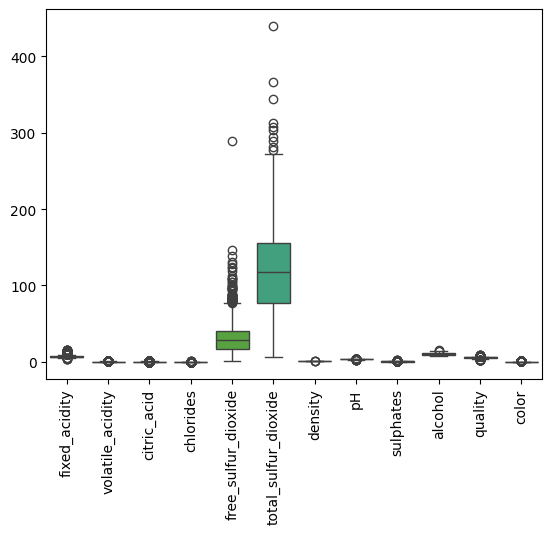

In [8]:
sns.boxplot(X)
plt.xticks(range(X.shape[1]), X.columns, rotation = 90)
plt.show()

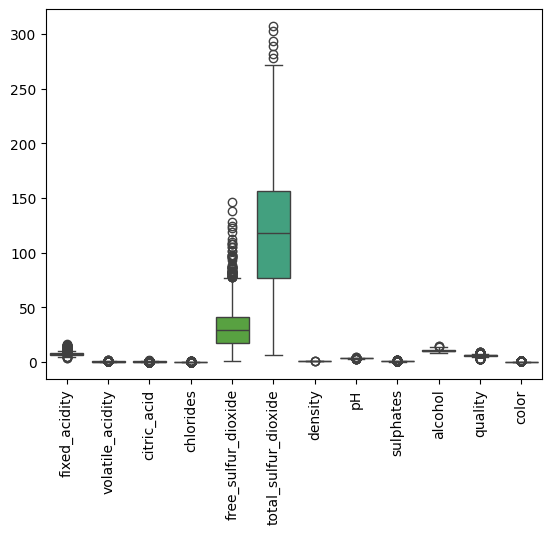

In [9]:
ot = list(X[X['free_sulfur_dioxide'] > 200].index) + list(X[X['total_sulfur_dioxide'] > 310].index)

X = X.drop(ot)
y = y.drop(ot)

sns.boxplot(X)
plt.xticks(range(X.shape[1]), X.columns, rotation = 90)
plt.show()

### Standarize

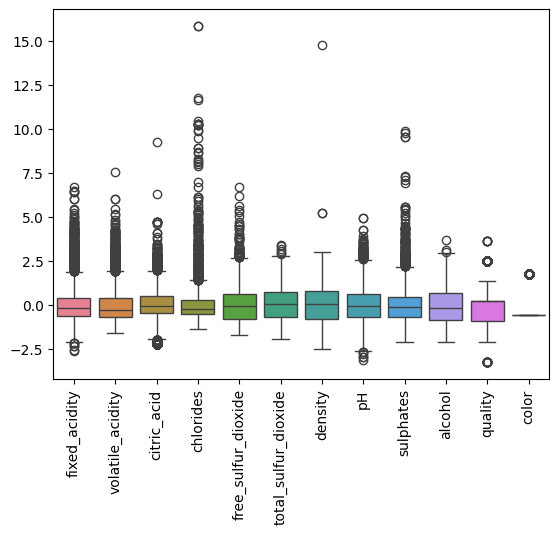

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

sns.boxplot(data=X)
plt.xticks(range(len(X_cols)), X_cols, rotation=90)
plt.show()

### Shape and NaNs

In [11]:
X.shape, y.shape

((6493, 12), (6493,))

In [12]:
y.isna().sum()

np.int64(0)

### 10 Rand Rows to NaN

Let's now replace 10 random values of 'residual sugar' with NaNs.

In [13]:
rand_rows = np.random.choice(X.shape[0], 10)

true_y = y.iloc[rand_rows]
y.iloc[rand_rows] = np.nan

In [14]:
X.shape, y.shape

((6493, 12), (6493,))

In [15]:
y.isna().sum()

np.int64(10)

Let's peek on 10 NaN values.

In [16]:
y.loc[rand_rows]

,residual_sugar
2634,1.8
2221,6.6
136,NaN
1200,NaN
3133,15.6
3939,4.8
2871,5.3
2382,14.1
5406,6.4
5671,12.7


### Torch Tensors

In [17]:
X = torch.tensor(X).float()
y = torch.from_numpy(y.to_numpy(dtype=np.float32))
y = y[:,None]

# Split

First we need to split data into train_dev set having all values, and test set having NaN values in 'residual sugar'.

In [18]:
train_dev_data, test_data, train_dev_labels, test_labels = np.delete(X, rand_rows, axis=0), X[rand_rows], np.delete(y, rand_rows, axis=0), y[rand_rows]

In [19]:
X.shape, y.shape

(torch.Size([6493, 12]), torch.Size([6493, 1]))

In [20]:
train_dev_data.shape, test_data.shape, train_dev_labels.shape, test_labels.shape

(torch.Size([6483, 12]),
 torch.Size([10, 12]),
 torch.Size([6483, 1]),
 torch.Size([10, 1]))

Now we can split into train set and dev set.

In [21]:
train_data, dev_data, train_labels, dev_labels = train_test_split(train_dev_data, train_dev_labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
dev_dataset = TensorDataset(dev_data, dev_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0], shuffle = False)
dev_dataloader = DataLoader(dev_dataset, batch_size = dev_data.shape[0], shuffle = False)

In [22]:
train_dataloader.dataset.tensors[0].shape

torch.Size([5186, 12])

In [23]:
test_dataloader.dataset.tensors[1].shape

torch.Size([10, 1])

In [24]:
dev_dataloader.dataset.tensors[0]

tensor([[-4.7436e-01, -4.8381e-01,  4.2223e-01,  ..., -9.1530e-01,
          2.0701e-01, -5.7160e-01],
        [ 2.3798e+00,  2.0766e-03,  1.3854e+00,  ..., -9.1530e-01,
         -9.3986e-01,  1.7495e+00],
        [-7.0579e-01, -1.1519e+00,  1.4702e-01,  ..., -4.1233e-01,
          2.0701e-01, -5.7160e-01],
        ...,
        [ 7.5989e-01, -9.6969e-01, -5.9381e-02,  ..., -8.3148e-01,
          2.0701e-01, -5.7160e-01],
        [ 1.2227e+00,  1.5812e+00, -1.9698e-01,  ..., -1.1668e+00,
         -9.3986e-01,  1.7495e+00],
        [-8.8659e-02, -6.0528e-01,  6.2863e-01,  ..., -1.5021e+00,
         -9.3986e-01, -5.7160e-01]])

# Model

In [25]:
def ModelCreate():
  class ModelArch(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(12, 32)
      self.f1 = nn.Linear(32, 64)
      self.f2 = nn.Linear(64, 32)
      self.output = nn.Linear(32, 1)
      self.dropout = nn.Dropout(.3)

    def forward(self, x):
      x = self.dropout(F.relu(self.input(x)))
      x = self.dropout(F.relu(self.f1(x)))
      x = self.dropout(F.relu(self.f2(x)))
      x = self.output(x)
      return x

  ann = ModelArch()
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(ann.parameters(), lr = 1e-3)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = .90, patience = 10, threshold = 1e-3)

  return ann, loss_fn, optimizer, scheduler

In [26]:
temp_X, temp_y = next(iter(train_dataloader))
ann, loss_fn, optim, scheduler = ModelCreate()
temp_y_hat = ann(temp_X)
temp_loss = loss_fn(temp_y_hat, temp_y_hat)
temp_mae = torch.mean(
    abs(temp_y_hat - temp_y)
)
print(f'First spin MAE: {temp_mae:.4f}')

First spin MAE: 5.2298


# Train

In [27]:
def ModelTrain(epochs, verbose, early_stop_patience):
  net, loss_fn, optimizer, scheduler = ModelCreate()

  losses = torch.zeros(epochs)
  train_maes = torch.zeros(epochs)
  test_maes = torch.zeros(epochs)

  best_mae = float('inf')
  best_model = None
  best_model_epoch = 0
  patience_counter = 0


  for epoch in range(epochs):
    net.train()

    batch_maes = torch.zeros(len(train_dataloader))
    batch_losses = torch.zeros(len(train_dataloader))

    for batch, (X, y) in enumerate(train_dataloader):

      y_hat = net(X)
      batch_loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

      # loss from this batch
      batch_losses[batch] = batch_loss

      # compute
      batch_mae = torch.mean(
          torch.abs(y_hat - y)
      )
      batch_maes[batch] = batch_mae

    #training accuracy
    train_mae = torch.mean(batch_maes)
    train_maes[epoch] = train_mae

    # and get  avg losses
    losses[epoch] = torch.mean(batch_losses)

    # test accuracy
    net.eval()
    X, y = next(iter(dev_dataloader))
    with torch.no_grad():
      y_hat = net(X)

    test_mae = torch.mean(
        torch.abs(y_hat - y)
    )
    test_maes[epoch] = test_mae

    # ---  SCHEDULER ---
    # scheduler.step(losses[epoch])

    # --- EARLY STOP ---
    if test_mae < best_mae:
      best_model = copy.deepcopy(net)
      best_mae = test_mae
      best_model_epoch = epoch
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter > early_stop_patience:
         print(f'\n\nStopping early at epoch {epoch} | Best MAE: {best_mae:.4f} (epoch {best_model_epoch})')
         break

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train MAE: {train_mae:.2f} | Test MAE: {test_mae:.2f} | Loss: {losses[epoch]:.2f} | LR: {scheduler.get_last_lr()[0]:.6f}')

  return train_maes, test_maes, losses, best_model_epoch, epoch, best_model

In [28]:
train_maes, test_maes, losses, best_model_epoch, early_stop_epoch, best_model = ModelTrain(epochs = 1000, verbose = True, early_stop_patience = 300)

Epoch: 0 | Train MAE: 4.13 | Test MAE: 2.55 | Loss: 35.12 | LR: 0.001000
Epoch: 10 | Train MAE: 1.43 | Test MAE: 0.95 | Loss: 4.42 | LR: 0.001000
Epoch: 20 | Train MAE: 1.27 | Test MAE: 0.99 | Loss: 4.22 | LR: 0.001000
Epoch: 30 | Train MAE: 1.19 | Test MAE: 0.81 | Loss: 3.17 | LR: 0.001000
Epoch: 40 | Train MAE: 1.16 | Test MAE: 0.80 | Loss: 3.05 | LR: 0.001000
Epoch: 50 | Train MAE: 1.21 | Test MAE: 0.88 | Loss: 3.48 | LR: 0.001000
Epoch: 60 | Train MAE: 1.11 | Test MAE: 0.84 | Loss: 2.76 | LR: 0.001000
Epoch: 70 | Train MAE: 1.07 | Test MAE: 0.79 | Loss: 2.48 | LR: 0.001000
Epoch: 80 | Train MAE: 1.04 | Test MAE: 0.94 | Loss: 2.32 | LR: 0.001000
Epoch: 90 | Train MAE: 1.07 | Test MAE: 0.82 | Loss: 2.49 | LR: 0.001000
Epoch: 100 | Train MAE: 1.07 | Test MAE: 0.85 | Loss: 2.58 | LR: 0.001000
Epoch: 110 | Train MAE: 1.02 | Test MAE: 0.84 | Loss: 2.34 | LR: 0.001000
Epoch: 120 | Train MAE: 1.03 | Test MAE: 0.84 | Loss: 2.19 | LR: 0.001000
Epoch: 130 | Train MAE: 1.01 | Test MAE: 0.84 | 

# Plots

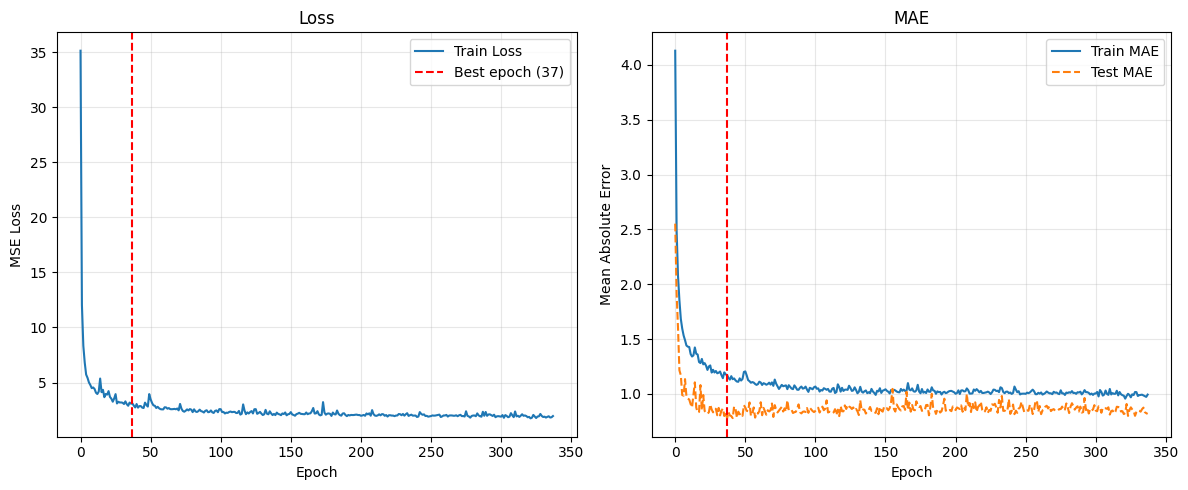

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- LOSS ---
ax[0].plot(losses[:early_stop_epoch].detach(), label='Train Loss', color='tab:blue')
ax[0].axvline(best_model_epoch, color='red', linestyle='--', label=f'Best epoch ({best_model_epoch})')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE Loss')
ax[0].grid(alpha=0.3)
ax[0].legend()

# --- MAE ---
ax[1].plot(train_maes[:early_stop_epoch].detach(), label='Train MAE', color='tab:blue')
ax[1].plot(test_maes[:early_stop_epoch].detach(), '--', label='Test MAE', color='tab:orange')
ax[1].axvline(best_model_epoch, color='red', linestyle='--')
ax[1].set_title('MAE')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Mean Absolute Error')
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

# Predictions

In [53]:
X, _ = next(iter(test_dataloader))
test_y_hat = best_model(X)
y_true = torch.tensor(true_y.values, dtype = torch.float32)
test_mae = torch.mean(torch.abs(test_y_hat.flatten() - y_true.flatten()))

print(f'Final Test MAE: {test_mae:.3f}')

Final Test MAE: 0.972


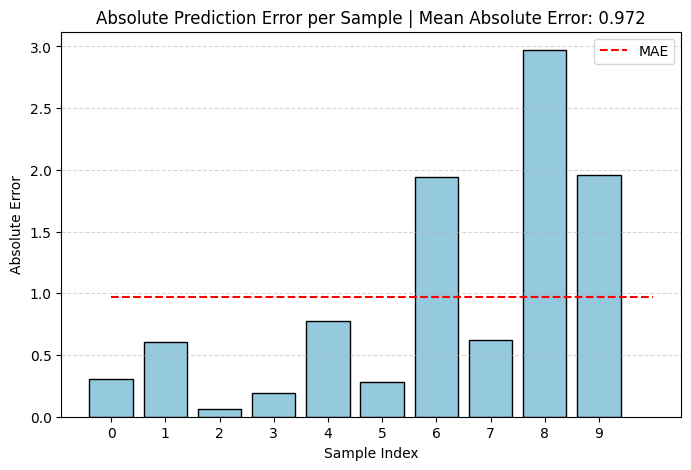

In [55]:
# prepare data
df_diff = pd.DataFrame({
    "True": y_true.numpy(),
    "Pred": test_y_hat.detach().numpy().flatten()
})
df_diff["Diff"] = abs(df_diff["True"] - df_diff["Pred"])

# barplot
plt.figure(figsize=(8,5))
sns.barplot(data=df_diff, x=df_diff.index, y="Diff", color="skyblue", edgecolor="black")
plt.xlabel("Sample Index")
plt.ylabel("Absolute Error")
plt.title(f"Absolute Prediction Error per Sample | Mean Absolute Error: {test_mae:.3f}")
plt.plot([0,10],[test_mae.detach(),test_mae.detach()], 'r--',label = 'MAE')
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Other NaN Filling Methods

/tmp/ipython-input-4259911602.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=maes, palette="crest", ax=ax[1])


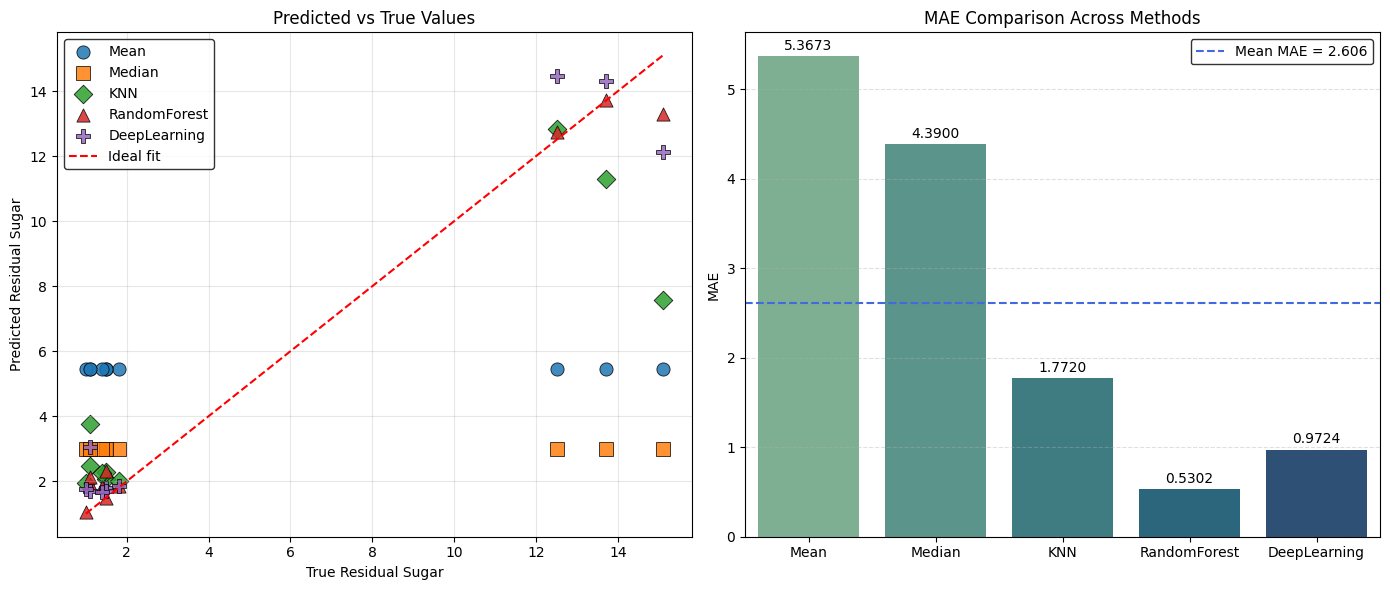

In [77]:
# --- STEP 1: merge all dataloaders ---
X_all = torch.cat([
    train_dataloader.dataset.tensors[0],
    dev_dataloader.dataset.tensors[0],
    test_dataloader.dataset.tensors[0]
], dim=0).numpy()

y_all = torch.cat([
    train_dataloader.dataset.tensors[1],
    dev_dataloader.dataset.tensors[1],
    test_dataloader.dataset.tensors[1]
], dim=0).numpy().flatten()

# --- STEP 2: build df ---
df_full = pd.DataFrame(X_all)
df_full["residual_sugar"] = y_all
df_full.columns = df_full.columns.astype(str)  # fix for sklearn

# --- STEP 3: define missing samples from test_dataloader ---
missing_idx = df_full[df_full["residual_sugar"].isna()].index
y_true = true_y  # already have the real values
X_full = df_full.drop(columns=["residual_sugar"])
y_full = df_full["residual_sugar"]
X_train_full = X_full.drop(index=missing_idx)
y_train_full = y_full.drop(index=missing_idx)
X_miss = X_full.loc[missing_idx]

# --- Mean ---
mean_y_hat = np.full(len(missing_idx), y_train_full.mean())
mean_mae = mean_absolute_error(y_true, mean_y_hat)

# --- Median ---
median_y_hat = np.full(len(missing_idx), y_train_full.median())
median_mae = mean_absolute_error(y_true, median_y_hat)

# --- KNN ---
knn_imp = KNNImputer(n_neighbors=5)
Xy_knn = df_full.copy()
Xy_knn.columns = Xy_knn.columns.astype(str)
Xy_knn = pd.DataFrame(knn_imp.fit_transform(Xy_knn), columns=Xy_knn.columns)
knn_y_hat = Xy_knn.loc[missing_idx, "residual_sugar"].values
knn_mae = mean_absolute_error(y_true, knn_y_hat)

# --- Random Forest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_full, y_train_full)
rf_y_hat = rf.predict(X_miss)
rf_mae = mean_absolute_error(y_true, rf_y_hat)

# --- Deep Learning ---
dl_y_hat = test_y_hat.detach().numpy().flatten()
dl_mae = test_mae.item()

# --- Results ---
methods = ["Mean", "Median", "KNN", "RandomForest", "DeepLearning"]
preds = [mean_y_hat, median_y_hat, knn_y_hat, rf_y_hat, dl_y_hat]
maes = [mean_mae, median_mae, knn_mae, rf_mae, dl_mae]

# --- Plots ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
colors = sns.color_palette("husl", len(methods))

# --- Scatter: Predicted vs True ---
colors = sns.color_palette("tab10", len(methods))
markers = ['o', 's', 'D', '^', 'P']  # circle, square, diamond, triangle, plus

for name, yhat, c, m in zip(methods, preds, colors, markers):
    ax[0].scatter(
        y_true, yhat,
        label=name,
        alpha=0.85,
        color=c,
        s=90,
        edgecolor="black",
        marker=m,
        linewidth=0.6
    )

ax[0].plot(
    [y_true.min(), y_true.max()],
    [y_true.min(), y_true.max()],
    "r--", label="Ideal fit", linewidth=1.5
)
ax[0].set_xlabel("True Residual Sugar")
ax[0].set_ylabel("Predicted Residual Sugar")
ax[0].set_title("Predicted vs True Values")
ax[0].legend(frameon=True, edgecolor="black")
ax[0].grid(alpha=0.3)

# --- Barplot: MAE ---
sns.barplot(x=methods, y=maes, palette="crest", ax=ax[1])

# Add value labels
for i, v in enumerate(maes):
    ax[1].text(i, v + 0.07, f"{v:.4f}", ha="center", fontsize=10, fontweight="medium")
# Plot mean MAE line
mean_line = np.mean(maes)
ax[1].axhline(mean_line, color="royalblue", linestyle="--", linewidth=1.5, label=f"Mean MAE = {mean_line:.3f}")
# Beautify
ax[1].set_ylabel("MAE")
ax[1].set_title("MAE Comparison Across Methods")
ax[1].grid(axis="y", linestyle="--", alpha=0.4)
ax[1].legend(frameon=True, edgecolor="black", loc="upper right")

plt.tight_layout()
plt.show()